In [54]:
#!conda env update --file environment.yml --prune

In [ ]:
import torch
import torch.nn as nn
import torchaudio
import torchaudio.functional as audioF

import numpy as np
import matplotlib.pyplot as plt

import os, random, glob, logging
logger=logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

from IPython.display import Audio
import tqdm

device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Utility

In [56]:
logger.debug(torchaudio.list_audio_backends())

DEBUG:__main__:['ffmpeg']


In [57]:
import pystoi
import pesq


def combine_audio(speech: torch.Tensor, noise: torch.Tensor, snr: torch.Tensor | int, to_int: bool = True) -> torch.Tensor:
    if not (torch.is_floating_point(speech) or torch.is_complex(speech)):
        # speech = torch.tensor(speech, dtype=torch.float64, device=speech.device)
        speech = speech.to(torch.float64,non_blocking=True)
    if not (torch.is_floating_point(noise) or torch.is_complex(noise)):
        # noise = torch.tensor(noise, dtype=torch.float64, device=noise.device)
        noise = noise.to(torch.float64,non_blocking=True)
    if not(type(snr) is torch.Tensor):
        snr = torch.tensor([snr])
    logger.debug(f"speech:{speech.ndim}, noise:{noise.ndim}, snr:{snr.ndim}")
    out = audioF.add_noise(speech, noise, snr)
    if to_int:
        out = out.to(torch.int16)
    return out

def calc_pesq(speech: np.ndarray, processed: np.ndarray) -> float:
    return pesq.pesq(fs=16000,ref=speech,deg=processed)

def calc_stoi(speech: np.ndarray, processed: np.ndarray) -> float:
    return pystoi.stoi(x=speech,y=processed,fs_sig=16000)

In [58]:
def plot_waveform(waveform, sample_rate=16000):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

In [59]:
from torch.utils.data import Dataset


ldrnd = random.Random(42)   #   Used for noise loading 

class AudioDataset(Dataset):
    def __init__(self, dir, root_dir=None):
        self.root_dir = root_dir
        if root_dir==None:
            self.root_dir = os.getcwd()+"\\data"
        logging.debug(self.root_dir + dir)
        self.data = glob.glob(dir + "\\**\\*.wav",root_dir=self.root_dir, recursive=True)
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        wave, _ = torchaudio.load(self.root_dir + "\\" + self.data[idx],normalize=False, format="wav")
        return wave

    def get(self,idx):
        wave, _ = torchaudio.load(self.root_dir + "\\" + self.data[idx],normalize=False, format="wav")
        return wave

class AudioCombiner():
    def __init__(self, speech_ds: AudioDataset, noise_ds: AudioDataset):
        self.idx = 0
        self.speech_ds = speech_ds
        self.noise_ds = noise_ds

    def next(self, snr):
        self.idx += 1
        if self.idx >= len(self.speech_ds):
            raise IndexError(f"Index {self.idx} out of bounds of speech dataset ({len(self.speech_ds)}).")
        speech = self.speech_ds.__getitem__(self.idx)
        noise = self.noise_ds.__getitem__(ldrnd.randint(0,len(self.noise_ds)-1))

        return audioF.add_noise(speech, noise, torch.tensor(snr))

    def set_index(self, idx):
        self.idx = idx

        
    
speech_train_dataset = AudioDataset("speech\\train")
noise_train_dataset = AudioDataset("noise\\train")

DEBUG:__main__:['speech\\train\\mayo.wav']
DEBUG:__main__:torch.Size([1, 145152])
DEBUG:__main__:torch.Size([1, 145152])
DEBUG:__main__:speech:2, noise:2, snr:1


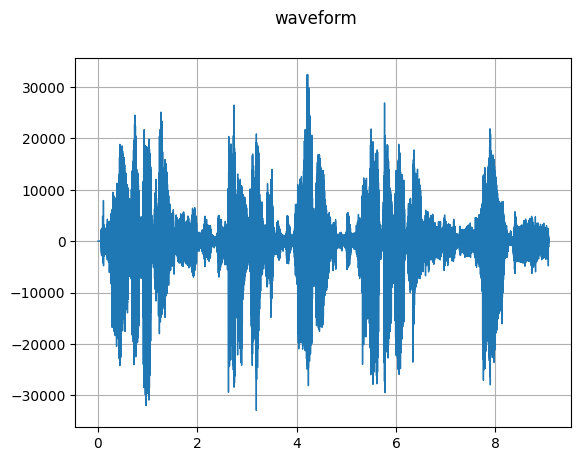

In [65]:
logger.debug(speech_train_dataset.data)
speech_1 = speech_train_dataset.get(0)
noise_1 = noise_train_dataset.get(0)
noise_1 = noise_1[:, : speech_1.shape[1]]
logger.debug(speech_1.shape)
logger.debug(noise_1.shape)
# plot_waveform(noise_1,16000)
# Audio(noise_1.numpy()[0],rate=16000)
mixed = combine_audio(speech_1, noise_1, 10, to_int=False)
plot_waveform(mixed)
Audio(mixed.numpy()[0],rate=16000)

# Models

## SEGAN

In [ ]:
def segan_train(models: tuple):
    generator, discriminator = models

## WaveCRN

In [ ]:
def wavecrn_train(model: nn.Module):


## RHR-Net

In [ ]:
def rhrnet_train(model):


## Wave-U-Net

In [ ]:
def waveunet_train(model):
    